In [93]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [94]:
acquisitions_fm5_path = {
    Path("data/fm5/uncalibrated/20240409_1634_fm5_55fe109cd137cs_LV0d5.fits"): ("109Cd", "137Cs"),
    Path("data/fm5/uncalibrated/20240409_1730_hermes_fm5_133Ba_LV0d5.fits"): ("133Ba",),
    Path("data/fm5/uncalibrated/20240409_1747_hermes_fm5_co57_LV0d5.fits"): ("57Co",),
    Path("data/fm5/uncalibrated/20240409_hermes_fm5_60Co_LV0d5.fits"): ("60Co",),
}

acquisitions_fm4_path = {
    Path("data/fm4/uncalibrated/240412_1430_hermes_fm4_55fe109cd137cs_20deg_LV0d5.fits"): ("109Cd", "137Cs"),
    Path("data/fm4/uncalibrated/20240509_hermes_fm4_20deg_133baLV0d5.fits"): ("133Ba",),
    Path("data/fm4/uncalibrated/20240509_hermes_fm4_20deg_co57_LV0d5.fits"): ("57Co",),
    Path("data/fm4/uncalibrated/20240509_hermes_fm4_20deg_co60.fits"): ("60Co",),
}
cd109_88 = 88.03
cs137_662 = 661.78
co60_1173 = 1173
co60_1332 = 1332
co57_122 = 122.1
ba_81 = 81.00
ba133_276 = 276.4
ba133_302 = 302.9
ba133_356 = 356.1

sources = {
    "109Cd": (cd109_88,),
    "137Cs": (cs137_662,),
    "60Co": (co60_1173, co60_1332),
    "57Co": (co57_122,),
    "133Ba": (ba_81, ba133_276, ba133_302, ba133_356),
}

In [111]:
from astropy.io import fits

with fits.open("data/hermes_corrfactor_20220101_v001.fits") as content:
    corr_factor = content[1].data
    
    
import pandas as pd

fit_fm5_results = pd.read_csv("fits_fm5.txt").sort_values("line")
fit_fm5_results_no133ba = fit_fm5_results[fit_fm5_results["source"] != " 133Ba"]

fit_fm4_results = pd.read_csv("fits_fm4.txt").sort_values("line")
fit_fm4_results_no133ba = fit_fm4_results[fit_fm4_results["source"] != " 133Ba"]



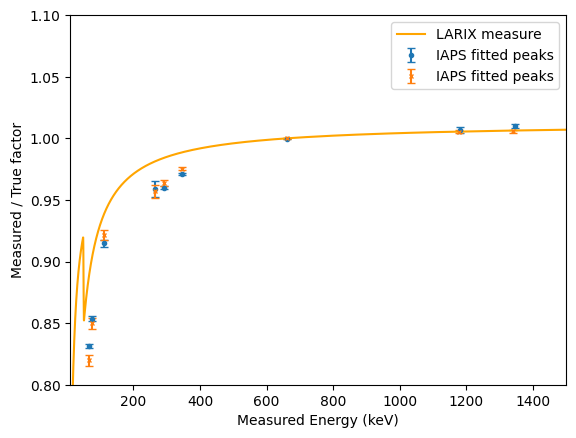

In [112]:
plt.errorbar(fit_fm5_results["mu"], fit_fm5_results["mu"] / fit_fm5_results["line"],
             yerr=5 * fit_fm5_results["muerr"] / fit_fm5_results["line"], label="IAPS fitted peaks", linestyle='',
             capsize=3, marker='o', ms=3)
plt.errorbar(fit_fm4_results["mu"], fit_fm4_results["mu"]/fit_fm4_results["line"], yerr=5 * fit_fm4_results["muerr"]/fit_fm4_results["line"], label="IAPS fitted peaks", linestyle='', capsize=3, marker='x', ms=3)

plt.plot(corr_factor["ENERGY"], corr_factor["CORRFACTOR"], color="orange", label="LARIX measure")
plt.ylabel("Measured / True factor")
plt.xlabel("Measured Energy (keV)")
plt.xlim(10, 1500)
plt.ylim(0.80, 1.1)
plt.legend()
plt.show()

In [113]:
from scipy.optimize import curve_fit

def model(x, a, b):
    return a / x + b

def dmodel(x, a):
    return - a / x ** 2

In [116]:
fit_results = pd.concat((fit_fm4_results, fit_fm5_results)).sort_values("mu")
fit_results_no133ba = pd.concat((fit_fm4_results_no133ba, fit_fm5_results_no133ba)).sort_values("mu")

popt, pcov = curve_fit(
    model, 
    xdata=fit_results_no133ba["mu"], 
    ydata=fit_results_no133ba["mu"] / fit_results_no133ba["line"],
    sigma=fit_results_no133ba["muerr"] / fit_results_no133ba["line"],
)
print(popt, pcov)

[-12.08473626   1.01780124] [[ 6.99151566e-02 -1.22439123e-04]
 [-1.22439123e-04  4.64680892e-07]]


In [117]:
from functools import partial

f = partial(model, a=popt[0], b=popt[1])
df = partial(dmodel, a=popt[0])

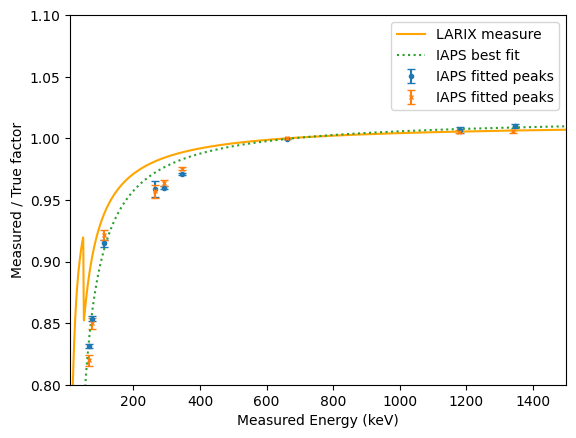

In [118]:
x = np.arange(50, 1500, .1)

plt.errorbar(fit_fm5_results["mu"], fit_fm5_results["mu"]/fit_fm5_results["line"], yerr=5 * fit_fm5_results["muerr"]/fit_fm5_results["line"], label="IAPS fitted peaks", linestyle='', capsize=3, marker='o', ms=3)
plt.errorbar(fit_fm4_results["mu"], fit_fm4_results["mu"]/fit_fm4_results["line"], yerr=5 * fit_fm4_results["muerr"]/fit_fm4_results["line"], label="IAPS fitted peaks", linestyle='', capsize=3, marker='x', ms=3)

plt.plot(corr_factor["ENERGY"], corr_factor["CORRFACTOR"], color="orange", label="LARIX measure")
plt.plot(x, f(x), label="IAPS best fit", linestyle="dotted")
plt.ylabel("Line center deviation [%]")
plt.ylabel("Measured / True factor")
plt.xlabel("Measured Energy (keV)")
plt.xlim(10, 1500)
plt.ylim(0.8, 1.1)
plt.legend()
plt.show()

In [153]:
xs = [ba_81, cd109_88, co57_122]
ys = [f(x) for x in xs]

xs = xs + [ba133_276, ba133_302, ba133_356]
ys = ys + [(265.054 + 264.541)/ 2 / ba133_276, (290.803 + 291.87) / 2 / ba133_302, (345.78 + 347.258) / 2 / ba133_356]

xs = xs + [cs137_662, co60_1173, co60_1332]
ys = ys + [1, f(co60_1173), f(co60_1332)]

xs = np.array(xs)
ys = np.array(ys)
dydx = df(xs)

In [185]:
from scipy.interpolate import CubicSpline, interp1d

interp = CubicSpline(
    x = xs,
    y = ys,
)
interp_larix = interp1d(corr_factor["ENERGY"], corr_factor["CORRFACTOR"])

In [231]:
def f1(xs):
    if not isinstance(xs, np.ndarray):
        xs = np.array(xs)
    spline_domain = co57_122, co60_1173
    mask_spline = (xs >= spline_domain[0]) & (xs <= spline_domain[1])
    mask_kshell = (xs <= 50.0)
    if np.any(mask_kshell | mask_spline):
        y = f(xs)
        y[mask_spline] = interp(xs[mask_spline])
        y[mask_kshell] = interp_larix(xs[mask_kshell])
        return y
    else:
        return f(xs)

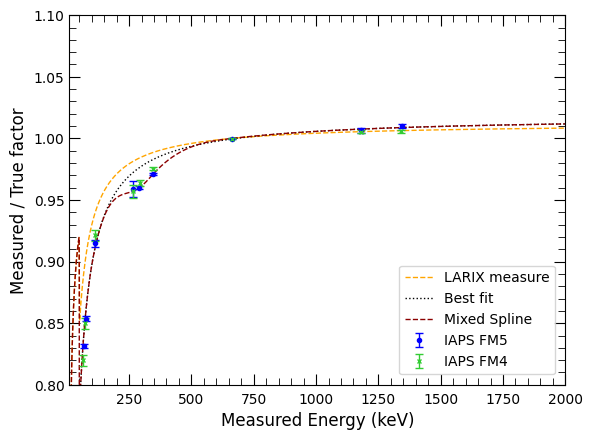

In [259]:
from functools import partial

x = np.arange(10.0, 5000, .1)


plt.plot(corr_factor["ENERGY"], corr_factor["CORRFACTOR"], color="orange", label="LARIX measure", linestyle="dashed")
plt.plot(x, f(x), label="Best fit", linestyle="dotted")
plt.plot(x, f1(x), label="Mixed Spline", color="darkred")

plt.errorbar(fit_fm5_results["mu"], fit_fm5_results["mu"]/fit_fm5_results["line"], yerr=5 * fit_fm5_results["muerr"]/fit_fm5_results["line"], label="IAPS FM5", linestyle='', capsize=3, marker='o', ms=3)
plt.errorbar(fit_fm4_results["mu"], fit_fm4_results["mu"]/fit_fm4_results["line"], yerr=5 * fit_fm4_results["muerr"]/fit_fm4_results["line"], label="IAPS FM4", linestyle='', capsize=3, marker='x', ms=3)

plt.ylabel("Line center deviation [%]")
plt.ylabel("Measured / True factor")
plt.xlabel("Measured Energy (keV)")
plt.xlim(10, 2000)
plt.ylim(0.8, 1.1)
plt.legend(loc=4)
plt.show()

In [227]:
from functools import partial

from source.calibrate import ImportedCalibration
from source.io import read_sdd_calibration_report, read_lightout_report, pandas_from_LV0d5
from source.eventlist import preprocess

class FakeConsole:
    def __init__(self):
        return 
    
    def log(self, msg):
        pass

configuration = {
    "binning": 10
}

sdd_fm5 = read_sdd_calibration_report(Path("data/fm5/fm5_20deg_newcalib/sdds.xlsx"))
slo_fm5 = read_lightout_report(Path("data/fm5/fm5_20deg_newcalib/lightoutput.xlsx")) 

sdd_fm4 = read_sdd_calibration_report(Path("data/fm4/fm4_20deg_newcalib/sdds.xlsx"))
slo_fm4 = read_lightout_report(Path("data/fm4/fm4_20deg_newcalib/lightoutput.xlsx")) 

def _calibrate_data(datafile, model, sdd_calibration, slo_calibration, configuration):
    data = pandas_from_LV0d5(datafile)
    data, _ = preprocess(data, model=model, filter_spurious=True, filter_retrigger=20E-6)
    return ImportedCalibration(
        model=model, 
        configuration=configuration,
        sdd_calibration=sdd_calibration,
        lightoutput=slo_calibration,
        console=FakeConsole(),
    )(data)

def histogram(data):
    bins = np.arange(50, 1500, .5)
    midpoints = (bins[:-1] + bins[1:]) / 2
    return np.histogram(data["ENERGY"], bins=bins)[0], midpoints

calibrate_fm5 = partial(_calibrate_data, model="fm5", sdd_calibration=sdd_fm5, slo_calibration=slo_fm5, configuration=configuration)
calibrate_fm4 = partial(_calibrate_data, model="fm4", sdd_calibration=sdd_fm4, slo_calibration=slo_fm4, configuration=configuration)


In [232]:
dataframes_fm5 = {sources: calibrate_fm5(datafile) for datafile, sources in acquisitions_fm5_path.items()}
dataframes_fm4 = {sources: calibrate_fm4(datafile) for datafile, sources in acquisitions_fm4_path.items()}

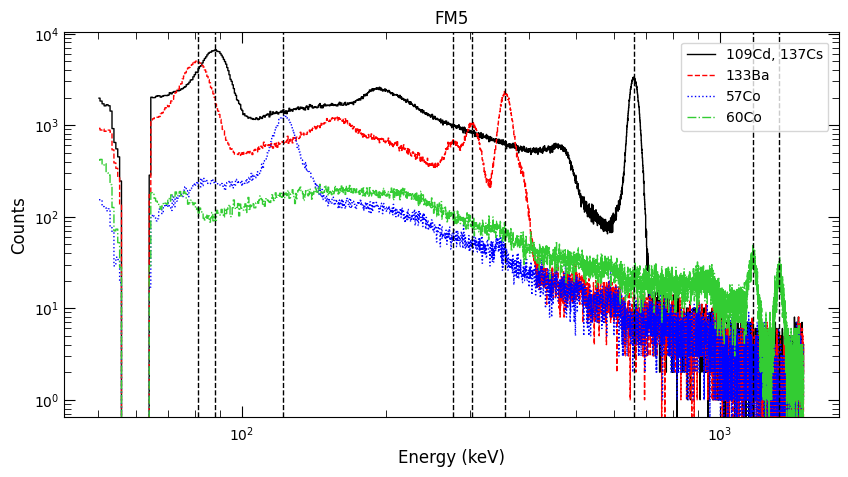

In [265]:
def get_mask(df):
    return (df["ENERGY"] > 10) & (df["EVTYPE"] == "S")

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for labels, data in dataframes_fm5.items():
    masked_events = data[get_mask(data)]["ENERGY"] 
    counts, midpoints = histogram({"ENERGY": data[get_mask(data)]["ENERGY"] / f1(data[get_mask(data)]["ENERGY"])})
    ax.step(midpoints, counts, where="mid", label=', '.join(map(str, labels)))
for source, emissions in sources.items():
    for emission in emissions:
        plt.axvline(emission, linestyle="--")
plt.loglog()
plt.legend()
plt.ylabel("Counts")
plt.xlabel("Energy (keV)")
plt.title("FM5")
plt.show()

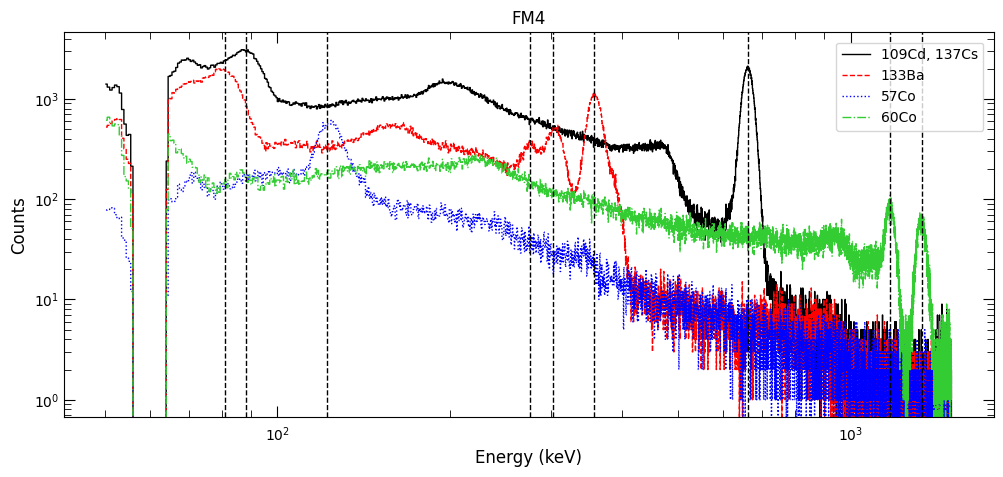

In [251]:
def get_mask(df):
    return (df["ENERGY"] > 10) & (df["EVTYPE"] == "S")

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
for labels, data in dataframes_fm4.items():
    masked_events = data[get_mask(data)]["ENERGY"] 
    counts, midpoints = histogram({"ENERGY": data[get_mask(data)]["ENERGY"] / f1(data[get_mask(data)]["ENERGY"])})
    ax.step(midpoints, counts, where="mid", label=', '.join(map(str, labels)))
for source, emissions in sources.items():
    for emission in emissions:
        plt.axvline(emission, linestyle="--")
plt.loglog()
plt.legend()
plt.ylabel("Counts")
plt.xlabel("Energy (keV)")
plt.title("FM4")
plt.show()

In [254]:
def to_fits(xs, f1, path="data/hermes_mixedsplice.fits"):
    df = pd.DataFrame({"ENERGY": xs, "CORRFACTOR": f1(xs)})

    header = fits.PrimaryHDU()
    output = fits.HDUList([header])
    table_quad = fits.BinTableHDU.from_columns(
        df.to_records(
            index=False,
            column_dtypes={"ENERGY": "float", "CORRFACTOR": "float"}
        )
    )
    output.append(table_quad)
    output.writeto(path, overwrite=True)
    
to_fits(corr_factor["ENERGY"], f1)